# &nbsp; **Числени методи и програмиране в инженерната практика**
***
* *докторска програма:* &nbsp;&nbsp;&nbsp; „**Проектиране и 
конструиране на автоматични и пилотирани летателни апарати**“ 

* *докторант:* &nbsp;&nbsp;&nbsp; **к-н инж. Николай Георгиев Кънчев**
* 30.05.2022 г.
***

## &nbsp; 1. Условие на задачата

Съставен прът е хванат конзолно между абсолютно твърдите стени $A$  и $D$. 

Дадени са дължините на частите на пръта в ненапрегнато състояние $𝑙
_1, 𝑙_2$ и $𝑙_3$, площите на напречните им сечения $𝑆_1, 𝑆_2$ и $𝑆_3$ и модула на еластичност на материала $E$. В сечение $B$ е приложена сила $F$. 

Tърсят се реакциите на опорите в стените, осевите напрежения в елементите на пръта и 
преместванията на сечения $B$ и $C$.
1.  Задачата да се реши по **метода на крайните елементи**.
2.  Да се представи алгоритъм на решението като последователност на формули и операции, или във вид на блок-схема.
3.  Да се представи код на програмата за решаване на задачата
4.  Да се демонстрира работоспособността на програмата като се въведат данни за които има просто аналитично решение
5.  Да се демонстрира работоспособността на програмата с произволен смислен набор входни данни.
***

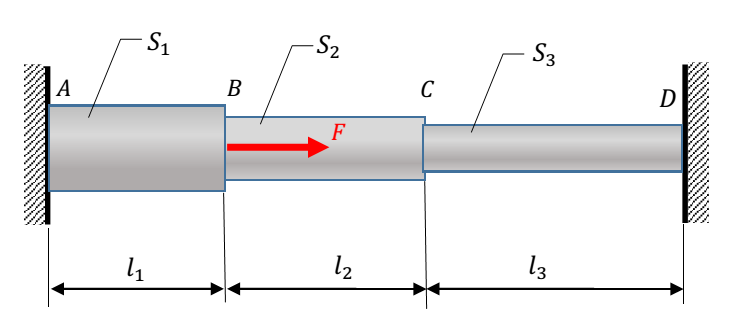

## &nbsp; 2. Валидация на числената процедура
***


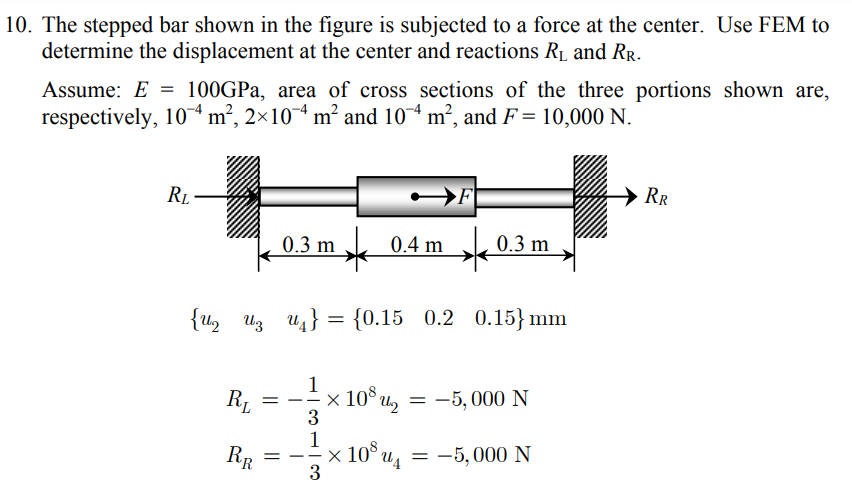

In [51]:
"""
#------------------------------------------------------------
# Created by:   Nikolai Kanchev, assistant professor
#------------------------------------------------------------
# Date: 		    27.05.2022
#------------------------------------------------------------
# Description: 	Finite element solver for 1D uniaxial bar system
#               with symbolic and Gauss quadrature evaluation of 
#               the elementary stiffness matrix and direct Gauss
#               elimination for the final linear system solution
#------------------------------------------------------------
"""

import numpy as np               # Библиотека с функции за работа с матрици
import matplotlib.pyplot as plt  # Библиотека с фунцкии за визуализация на данни
import sympy as sp               # Библиотека с функции за символни операции

################################################################################
# ВХОДНИ ДАННИ                                                                 #
################################################################################
# Модул на еластичност
E = 100*10**9                    # 100 GPa

# Дължини на прътовете, [m]
l = np.array([0.3, 0.2, 0.2, 0.3])
# Площи на напречните сечения, [m^2]
A = np.array([1e-4, 2*1e-4, 2*1e-4, 1e-4])

# Възлови сили, [N]  (->: (+); <-: (-))
F = np.array([0, 0, 10000, 0, 0])

# Гранични условия
U_dofs = np.array([0, 1, 1, 1, 0]).astype(np.float64)

################################################################################                                                                #
################################################################################
# Брой крайни елементи
eNum = len(l)

# Брой степени на свобода на отделния краен елемент
edof = 2

# Брой възли
nNum = eNum + 1

# Брой степени на свобода
dofs = nNum * 1

print("-------------------------\n Крайно-елементен модел: \n-------------------------\n >> Брой крайни елементи: ",
      eNum, "\n >> Брой възли: ", nNum, "\n >> Брой степени на свобода: ",
      dofs, "\n >> Фиксирани възли: ", np.array((np.where(U_dofs == 0)[0]))+1, 
      "\n >> Натоварване е приложено към възли: ", np.array((np.nonzero(F)))+1, 
      " съответно с величина и посока ", F[np.nonzero(F)],"N")
################################################################################
################################################################################

-------------------------
 Крайно-елементен модел: 
-------------------------
 >> Брой крайни елементи:  4 
 >> Брой възли:  5 
 >> Брой степени на свобода:  5 
 >> Фиксирани възли:  [1 5] 
 >> Натоварване е приложено към възли:  [[3]]  съответно с величина и посока  [10000] N


In [52]:
# Функция за символно пресмятане на локалната матрица на коравина
def ke_2(bar_E, bar_area, bar_length):
  # Дефиниране на символни променливи
  x, l = sp.symbols("x, l")
  E, A = sp.symbols("E, A")

  # Дефиниране на символни функции
  N1 = sp.Function("N1")(x)
  N2 = sp.Function("N2")(x)

  N1 = 1 - x/l
  N2 = x/l

  # Дефиниране на символните матрици N и B
  N = sp.Matrix([[N1, N2]])        # Вектор на интерполационните функции N1 и N2
  B = N.diff(x)                    # Вектор с производните на N1 и N2

  # Символно пресмятане на елемнтарната матрица на коравина
  expr = sp.transpose(B)*B * E * A
  k = sp.integrate(expr, [x,0,l])
  k_num = k.subs({A: bar_area, E: bar_E, l: bar_length})
  return np.array(k_num).astype(np.float64)

# Тестване на функцията
ke = ke_2(E, A[0], l[0])
ke

array([[ 33333333.33333334, -33333333.33333334],
       [-33333333.33333334,  33333333.33333334]])

In [53]:
# Функция за пресмятане на функциите на формата в естествена координатна система
def shapeFunctions(ksi):
  N1 = (1-ksi)/2
  N2 = (1+ksi)/2
  dN1 = -0.5
  dN2 = 0.5
  return [[N1, N2],[dN1, dN2]]

# Функция за числено интегриране на матрицата на коравина чрез квадратури на Гаус
def ke_2_Gauss(bar_E, bar_area, bar_length, gaussPoints=1):  
  # Пресмятане на Якобиана на линейната трансформация
  detJ = bar_length/2         # dx/dξ
  invJ = 1/detJ

  # Пресмятане на производните на функциите на формата в естествени координати
  # >> При една Гаусова точка (n=1): ξ=0, w=2
  ksi = 0
  w = 2

  B = np.zeros([edof])
  for i in range(0,edof):
    B[i] = shapeFunctions(ksi)[1][i]*invJ
  
  BT = B.reshape((-1,1))
  BTB = BT * B

  ke = np.zeros([edof, edof])
  ke = ke + BTB*w*detJ*bar_E*bar_area

  return ke

# Тестване на функцията
ke = ke_2_Gauss(E, A[0], l[0])
ke

array([[ 33333333.33333334, -33333333.33333334],
       [-33333333.33333334,  33333333.33333334]])

In [55]:
# Сглобяване на глобалната матрица на коравина
# При модел с три пръта => 4 степени на свобода => размерност 4 х 4
Ks = np.zeros((dofs, dofs))     # Матрица на коравина, синтезирана чрез символна алгебра
Kg = np.zeros((dofs, dofs))     # Матрица на коравина, синтезирана чрез квадратури на Гаус

for i in range(0,eNum):
  ke_s = ke_2(E,A[i],l[i])
  ke_g = ke_2_Gauss(E,A[i],l[i])
  di = edof
  Ks[i:i+di, i:i+di] = Ks[i:i+di, i:i+di] + ke_s
  Kg[i:i+di, i:i+di] = Kg[i:i+di, i:i+di] + ke_g

print("-----------------------------")
print("Глобална матрица на коравина: (символна алгебра)")
print("-----------------------------")
print(Ks)

print("\n-----------------------------")
print("Глобална матрица на коравина: (числено интегриране, метод на Гаус)")
print("-----------------------------")
print(Kg)

errK = abs((Ks - Kg)/Ks)*100
print("\n---------------------------------------")
print("Относителна грешка на глобалната матрица:")
print("-----------------------------------------")
print(errK)

-----------------------------
Глобална матрица на коравина: (символна алгебра)
-----------------------------
[[ 3.33333333e+07 -3.33333333e+07  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.33333333e+07  1.33333333e+08 -1.00000000e+08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+08  2.00000000e+08 -1.00000000e+08
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+08  1.33333333e+08
  -3.33333333e+07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.33333333e+07
   3.33333333e+07]]

-----------------------------
Глобална матрица на коравина: (числено интегриране, метод на Гаус)
-----------------------------
[[ 3.33333333e+07 -3.33333333e+07  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.33333333e+07  1.33333333e+08 -1.00000000e+08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+08  2.00000000e+08 -1.00000000e+08
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+08  1.33333333e+08
  -3.33333333e+0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [56]:
# Дефиниране на вектор със свободните степени на свобода
freeDofs = np.nonzero(U_dofs)

# Дефиниране на вектор с фиксираните степени на свобода
fixedDofs = np.where(U_dofs == 0)[0]

# Извличане на подматрица от глобалната матрица на коравина, съответстваща
# на свободните степени на свобода
K_free = Kg.copy()

n=0
for i in fixedDofs:
  K0 = np.delete(K_free,i-n,0)
  K_free = np.delete(K0,i-n,1)
  n=n+1

print("--------------------------------------------------------------")
print("Глобална матрица на коравина за свободните степени на свобода:")
print("--------------------------------------------------------------")
print(K_free)

F_free = F[freeDofs].reshape((-1,1))
print("\n-------------------------------------------------------------------")
print("Глобален вектор на натоварването при свободните степени на свобода:")
print("-------------------------------------------------------------------")
print(F_free)

--------------------------------------------------------------
Глобална матрица на коравина за свободните степени на свобода:
--------------------------------------------------------------
[[ 1.33333333e+08 -1.00000000e+08  0.00000000e+00]
 [-1.00000000e+08  2.00000000e+08 -1.00000000e+08]
 [ 0.00000000e+00 -1.00000000e+08  1.33333333e+08]]

-------------------------------------------------------------------
Глобален вектор на натоварването при свободните степени на свобода:
-------------------------------------------------------------------
[[    0]
 [10000]
 [    0]]


In [57]:
# Числено решение на СЛАУ чрез елиминация на Гаус: O(n^3)
def gaussElimination(K_free,f_free):
  K = K_free.copy()
  f = f_free.copy()

  n = len(f)
  u = np.zeros([n,1])

  # Фаза на елиминация
  for k in range(0,n-1):        # Цикъл, обхождащ всички редове надолу
    for i in range(k+1,n):      # Цикъл, изменящ редовете под текущия ред k
      if K[i,k] != 0.0:
        factor = K[i,k]/K[k,k]  # Пресмятане на коефициента на трансформация за ред i
        K[i,(k+1):n] = K[i,(k+1):n] - factor*K[k,(k+1):n]  # Трансформация на ред i
        f[i] = f[i] - factor*f[k]
  
  # Заместване назад
  for k in range(n-1,-1,-1):
    u[k] = (f[k] - np.dot(K[k,k+1:n],u[k+1:n]))/K[k,k]

  return u

u_gaussElim = gaussElimination(K_free, F_free)
u_gaussElim

array([[0.00014999],
       [0.00019998],
       [0.00014998]])

In [58]:
# Решаване на СЛАУ за намиране на неизвестните възлови премествания, 
# при които се реализира минимум на пълната потенциална енергия на системата
u_solution = np.linalg.solve(K_free, F_free)
u_solution

array([[0.00015],
       [0.0002 ],
       [0.00015]])

> Преместване във възел № 1 :    0.0  mm;
> Преместване във възел № 2 :    0.14999999999999997  mm;
> Преместване във възел № 3 :    0.19999999999999996  mm;
> Преместване във възел № 4 :    0.14999999999999997  mm;
> Преместване във възел № 5 :    0.0  mm;


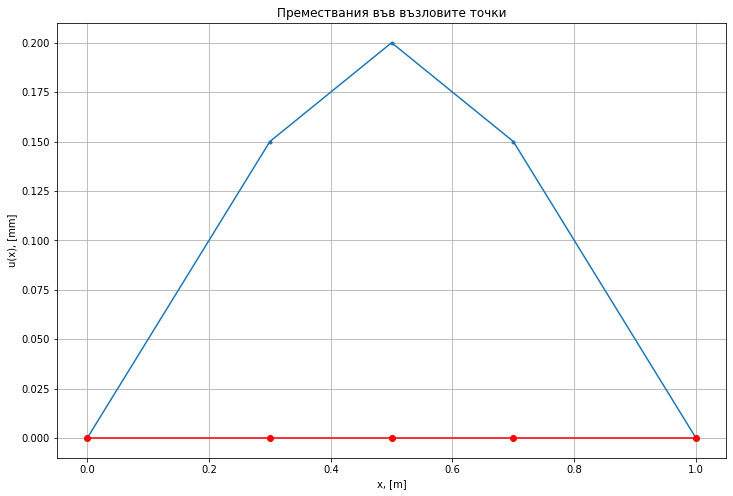

In [59]:
U_dofs[freeDofs] = u_solution.T
for i in range(len(U_dofs)):
  print("> Преместване във възел №",i+1,":   ",U_dofs[i]*1e3," mm;")

# Визуализация на преместванията във всички възли
counter = 0
l_list = [counter]
for i in range(len(l)):
  counter = counter + l[i]
  l_list.append(counter)

plt.rcParams["figure.figsize"] = (12,8)

plt.plot(l_list,U_dofs*1e3, '.-')
plt.grid()
plt.title("Премествания във възловите точки")
plt.xlabel("x, [m]")
plt.ylabel("u(x), [mm]")

plt.plot(l_list,np.zeros((len(l_list))),'o-r')

In [60]:
# Пресмятане на нормалните напрежения във всеки от крайните елементи
length = l.sum()
B = np.array([-1/length, 1/length])

elemStrains = []
elemStresses = []
for i in range(len(l)):
  estrain = np.dot(B,U_dofs[i:i+2].reshape(2,1))[0]
  elemStrains.append(estrain)
  elemStresses.append(E*estrain)
  print("> Нормално напрежение в краен елемент №",i+1,":   ", round(elemStresses[i],3)," Pa;")

> Нормално напрежение в краен елемент № 1 :    15000000.0  Pa;
> Нормално напрежение в краен елемент № 2 :    5000000.0  Pa;
> Нормално напрежение в краен елемент № 3 :    -5000000.0  Pa;
> Нормално напрежение в краен елемент № 4 :    -15000000.0  Pa;


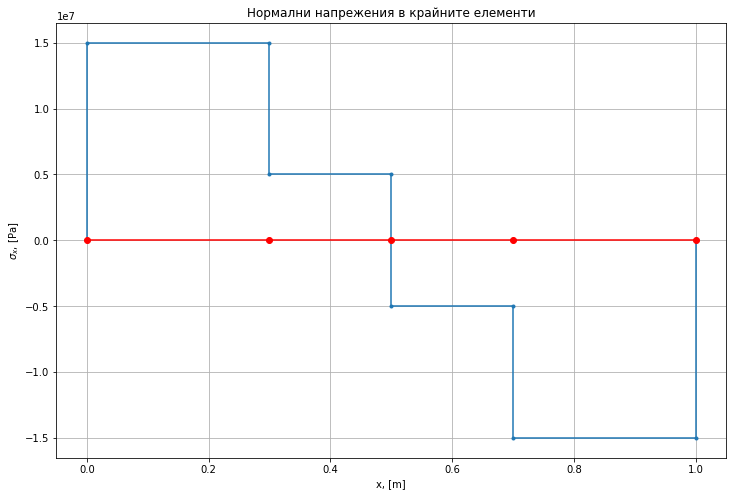

In [61]:
# Визуализация на нормалните напрежения във всеки от крайните елементи
xPts = []
stresses = []

for i in range(len(l)+1):
  xPts.append(l_list[i])
  xPts.append(l_list[i])
  if i==0:
    stresses.append(0)
    stresses.append(elemStresses[i])
  elif i==len(l):
    stresses.append(elemStresses[i-1])
    stresses.append(0)
  else:
    stresses.append(elemStresses[i-1])
    stresses.append(elemStresses[i])


plt.plot(xPts,stresses, '.-')
plt.grid()
plt.title("Нормални напрежения в крайните елементи")
plt.xlabel("x, [m]")
plt.ylabel(r"$\sigma_x$, [Pa]")

plt.plot(l_list,np.zeros((len(l_list))),'o-r')

In [62]:
# Пресмятане на реакциите във всеки от възлите
R = np.dot(Kg,U_dofs)

for i in range(len(R)):
  print("> Реакция във възел №",i+1,":   ",round(R[i],3)," N;")

> Реакция във възел № 1 :    -5000.0  N;
> Реакция във възел № 2 :    0.0  N;
> Реакция във възел № 3 :    10000.0  N;
> Реакция във възел № 4 :    0.0  N;
> Реакция във възел № 5 :    -5000.0  N;
